# Contents

- [Reiteration of Problem Statement](#Reiteration-of-Problem-Statement)
- [Methodology](#Methodology)
- [Baseline](#Baseline)
- [Model with Base Features](#Model-with-Base-Features)
- [Further Modelling - Polynomial Feature Generation](#Further-Modelling---Polynomial-Feature-Generation)
- [Further Modelling - SMOTE](#Further-Modelling---SMOTE)
- [Model Evaluaton](#Model-Evaluaton)
- [Cost-Benefit Analysis of Spraying](#Cost-Benefit-Analysis-of-Spraying)
- [Conclusions](#Conclusions)

# Reiteration of Problem Statement

In view of the recent epidemic in Windy City of Chicago state affecting the state population, we aim to build a classifier model to make predictions on the possibility of West Nile Virus occurence on various locations of interest, which could be used to aid the deployment of pesticides in the fight for public health and safety. 
The model would be build using collected data related to mosquito population from the surveillance and control system setup by Deparment of Public Health. 

In addition, a cost-benefit analysis would be conducted on the cost benefits for the use of pesticides as a response in managing the epidemic. 

# Methodology

The methodology used during the modelling process can be described as follows:

**1. Baseline**
- Apply baseline classifier to set the baseline scores for metrics that we _must_ beat

**2. Modelling with Base Features**
- Run various models with base set of 49 features (obtained after final EDA & feature engineering from before)

**3. Feature Expansion with Polynomial Feature Generation**
- Try to improve metrics by increasing number of features
- Use PolynomialFeatures to generate polynomial and interaction features to uncover new patterns in the data
- 2 methods to try and reduce noise/dimensionality:
    - Principal Component Analysis (PCA)
    - Filtering features by correlation with target
- Run models for each set of features

**4. Addressing Class Imbalance with SMOTE**
- Try to improve recall score & address class imbalance with SMOTE
- Run models with base set of 49 features, but fit to SMOTED dataset

**5. Model Evaluation**
- Compare the top 2 models from each method
- Evaluate metrics, keeping in mind problem statement
- Selecting best model based on balance of ROC-AUC score & recall
    - Evaluate most important features
    - Prepare Kaggle submission

For each step, we carried out the relevant preprocessing & modelling steps, gridsearching over several hyperparameters for each model to achieve the best results. The metric we optimised for was **ROC-AUC** score for the holdout set. We also gathered other metrics including F1 score, Precision, Recall and Accuracy.

**<u>Models</u>**

We considered the following 5 models throughout our process:
1. Logistic Regression
    - Simple & effective for binary classification problems
2. Gradient Boost
    - Produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees, using gradient descent algorithms
3. XG Boost
    - Similar to gradient boost, but it uses a more regularised model formalisation to control over-fitting
4. Random Forest
    - Constructs decision trees at training time and outputs the class that is the mode of the classes
5. Extra Trees
    - Similar to Random Forest. However, the splits of the trees in the Random Forest are deterministic. It is random for extratrees

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [3]:
train = pd.read_csv('../assets/train_combined.csv', parse_dates=['date'])
test = pd.read_csv('../assets/test_combined.csv', parse_dates=['date'])

# Baseline

## Preprocessing

In [4]:
# Define X, y
y = train['wnvpresent']
X = train.drop(columns=['wnvpresent','date'])

# Train/test split our data.
X_train, X_holdout, y_train, y_holdout = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=0.30,
                                                          random_state=42)

In [115]:
# Baseline
y.value_counts(normalize=True)

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

The baseline accuracy score would be 0.946 (where we predict every row to be 0). However, we will be optimising for ROC-AUC for this project. From kaggle, the baseline ROC-AUC score to beat would be **0.500**.



# Model with Base Features

We will first try the various models with our existing set of features to compare which models perform better.

## Models & Parameters

We will instantiate the models with various parameters to gridsearch through.

In [5]:
# Logistic Regression
logreg = LogisticRegression(
    solver='liblinear',
    max_iter=1000, 
    random_state=42,
)

logreg_params = {
    'clf__penalty': ['l1', 'l2'],
    'clf__C': [0.1, 0.5, 1, 1.5, 2.5]
}

In [6]:
# Gradient Boost
gb = GradientBoostingClassifier(random_state=42)

gb_params = {
    'clf__learning_rate': [0.05, 0.1, 0.15],
    'clf__max_depth': [2, 3]
}

In [7]:
# XGBoost
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)

xgb_params = { 
    'clf__max_depth': [3, 4], #Depth of tree (higher value implies likely overfit)
    'clf__gamma' : [0.1, 0.2 , 0.3], #Min loss reduction required for further partition
    'clf__learning_rate' : [0.1, 0.2], #step size feature weight shrinkage
}

In [8]:
# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_params = {
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [4, 5, 6]
}

In [9]:
# Extra Trees
et = ExtraTreesClassifier(random_state=42, n_jobs=-1)

et_params = {
    'clf__n_estimators': [50, 75, 100],
    'clf__max_depth': [4, 5, 6]
}

In [10]:
# List of classifiers & params
classifiers = [
    (logreg, logreg_params),
    (gb, gb_params),
    (xgb, xgb_params),
    (rf, rf_params),
    (et, et_params)
]

In [11]:
# Instantiate list to store results
results = []

In [12]:
# Create function to gridsearch through models and store metrics
def model(clf, clf_params):
    
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(X_train, y_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_preds = grid.predict(X_holdout)
    y_pred_probas = grid.predict_proba(X_holdout)[:, 1]
    y_train_pred_probas = grid.predict_proba(X_train)[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results.append(scores)
    
    return pipe

In [13]:
# Run through gridsearch for every model
for (clf, clf_params) in classifiers:
    model(clf, clf_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.15, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_w

C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42)
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}


C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Results sorted by holdout ROC-AUC
pd.DataFrame(results).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"XGBClassifier(base_score=None, booster=None, c...",0.928438,0.870347,0.095890,0.777778,0.051095,0.948093
1,GradientBoostingClassifier(random_state=42),0.891929,0.869525,0.055944,0.666667,0.029197,0.946913
2,"RandomForestClassifier(n_jobs=-1, random_state...",0.906933,0.852818,0.000000,0.000000,0.000000,0.946127
3,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",0.868666,0.841603,0.000000,0.000000,0.000000,0.946127
4,"LogisticRegression(max_iter=1000, random_state...",0.852296,0.837027,0.000000,0.000000,0.000000,0.945733


As seen above, the best performing model is the `XGBoost` Classifier, which had a decent holdout ROC-AUC score of 0.87. Conversely, `LogisticRegression` was the worst performing model in terms of every metric.

Another thing we notice is that the recall scores were quite low across the board, with only `XGBoost` surpassing getting higher than 0.05. From the high precision & accuracy scores, we can infer that this is most likely due to the class imbalance of the dataset as mentioned earlier in the EDA.

We will explore a couple of methods to try and improve the metrics:
1. Feature Expansion (Polynomial Feature Generation)
    - To try and improve target metric by adding more features to the model
2. SMOTE
    - To try and address the class imbalance issue

# Further Modelling - Polynomial Feature Generation

We will try generating polynomial features on our training data to see if we can improve the metrics of our models. PolynomialFeatures will generate new polynomial and interaction features, exponentially increasing the number of features for our model. This might uncover some important features that exist in higher dimensions or as an interaction between two separate features.

## Preprocessing

In [15]:
# Poly by power of 2.  
pf = PolynomialFeatures(degree=2, include_bias=False)  
# Fit and transform our X data using Polynomial Features.  
X_poly = pf.fit_transform(X)

# Train/test split our data.
Xp_train, Xp_holdout, y_train, y_holdout = train_test_split(X_poly,
                                                            y,
                                                            stratify=y,
                                                            test_size=0.3,
                                                            random_state=42)      

# Instantiate our StandardScaler.
ss = StandardScaler()
# Scale X_train.
Xp_train_sc = ss.fit_transform(Xp_train)
# Scale X_test.
Xp_holdout_sc = ss.transform(Xp_holdout)

In [16]:
Xp_train_sc.shape

(5932, 1274)

As seen above, this generates over a thousand features, many of which might not be meaningful to our model. We will explore a couple of methods to reduce the dimensionality or complexity of our model to achieve better performance

## PCA

1) We perform PCA to reduce the dimensionality of our models, selecting the best principal components to be used.

**Two assumptions that PCA makes:**

 -- A. **Linearity:** PCA detects and controls for linear relationships, so we assume that the data does not hold nonlinear relationships (or that we don't care about these nonlinear relationships).
    - We are using our covariance matrix to determine important "directions," which is a measure of the linear relationship between observations!
    
 -- B. **Large variances define importance:** If data is spread in a direction, that direction is important! If there is little spread in a direction, that direction is not very important.

2) GridsearchCV to find the best parameters for each model. Compare the best performing model for each feature set, then evaluate the metrics

In [24]:
# Instantiate PCA.
pca = PCA(random_state=42)
# Fit PCA on the training data.
pca.fit(Xp_train_sc)
# Transform PCA on the training data.
Z_train = pca.transform(Xp_train_sc)
# Don't forget to transform the test data!
Z_holdout = pca.transform(Xp_holdout_sc)

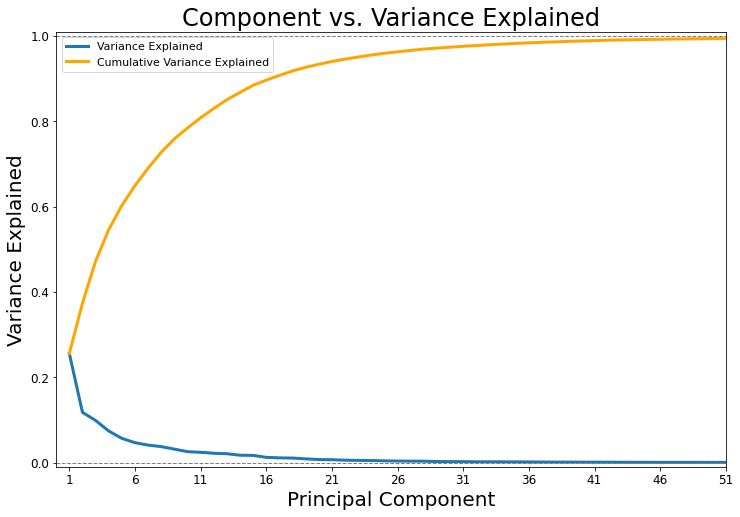

In [25]:
# Plot the variance explained (and cumulative variance explained).

# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
#print(f'Explained variance (first 50 components): {np.round(var_exp[:50],3)}')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
#print(f'Cumulative explained variance (first 50 components): {np.round(cum_var_exp[:50],3)}')

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,31])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 51, 5), range(1, 52, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

Based on our graph above, we can observe that the top 30 components are able to explain the 97.6% of the variance, top40 at 98.9% and all 50 at 99.4%.  
However, we will perform GridSearch to find the best components number to fit into our model.

In [26]:
# Instantiate result list
results_pca = []

#create a function to gridsearch all models
def model_pca(clf, clf_params, n_comp):
    
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('pca', PCA(n_components=n_comp, random_state=42)),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(Xp_train, y_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf, 'PCA Components': n_comp}
    y_preds = grid.predict(Xp_holdout)
    y_pred_probas = grid.predict_proba(Xp_holdout)[:, 1]
    y_train_pred_probas = grid.predict_proba(Xp_train)[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results_pca.append(scores)
    
    return pipe

In [27]:
# Iterate function through different n_comps
for n_comp in [30, 40, 50]:
    for (clf, clf_params) in classifiers:
        model_pca(clf, clf_params, n_comp)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.05, 'clf__max_depth': 3}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_w

In [28]:
# Display results sorted by holdout ROC-AUC score
pd.DataFrame(results_pca).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,PCA Components,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"RandomForestClassifier(n_jobs=-1, random_state...",50,0.940975,0.846118,0.028169,0.400000,0.014599,0.945733
1,GradientBoostingClassifier(random_state=42),50,0.907362,0.845655,0.054422,0.400000,0.029197,0.945340
2,"RandomForestClassifier(n_jobs=-1, random_state...",30,0.938872,0.845409,0.028169,0.400000,0.014599,0.945733
3,GradientBoostingClassifier(random_state=42),40,0.926881,0.845117,0.147239,0.461538,0.087591,0.945340
4,"XGBClassifier(base_score=None, booster=None, c...",50,0.923920,0.844387,0.028169,0.400000,0.014599,0.945733
5,"RandomForestClassifier(n_jobs=-1, random_state...",40,0.936795,0.842802,0.028169,0.400000,0.014599,0.945733
6,GradientBoostingClassifier(random_state=42),30,0.899807,0.842797,0.027586,0.250000,0.014599,0.944554
7,"XGBClassifier(base_score=None, booster=None, c...",40,0.919636,0.841214,0.028369,0.500000,0.014599,0.946127
8,"LogisticRegression(max_iter=1000, random_state...",50,0.859119,0.839885,0.014085,0.200000,0.007299,0.944947
9,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",50,0.888381,0.839691,0.014286,0.333333,0.007299,0.945733


<u>**Polynomial + PCA Summary**</u>

Firstly, we expanded the features using polynomial features with degree of 2. This created 1000+ features in our feature set. 
Then we used PCA to try to reduce the dimensionality.  
As observed above, we can explain up to 99.4% of the variation in our data with 50 components at best.

During our modelling process, we tried multiple models (Logistic reg, AdaBoost, Gradient Boost, Random Forest, Extra Trees and XGBoost.

From the model summary table, we noticed that the best 2 models were `RandomForest` and `GradientBoost`. They did perform well on our accuracy score and ROC-AUC score, although the recall scores were quite low. The holdout ROC-AUC score that we optimised for only yielded 0.846 at best. We will compare these models with others during our model evaluation later on.

## Filtering by Correlation with Target

**Feature Selection**

We will filter the features using Pearson's correlation with 4 different cutoff points for correlation (0, 0.01, 0.05, 0.1). This will help us gradually reduce the number of features until we find a feature set that gives us the best holdout ROC-AUC score.

We will gridsearch through the same parameters for the same set of models as before, except that we will be using a different set of features

In [29]:
# Convert the polynomial expansion np.arrays to dataframe
X_poly = pd.DataFrame(X_poly, columns = pf.get_feature_names(X.columns))
Xp_train = pd.DataFrame(Xp_train, columns = pf.get_feature_names(X.columns))
Xp_holdout = pd.DataFrame(Xp_holdout, columns = pf.get_feature_names(X.columns))

In [30]:
# Sorting by correlation to y
corr_df = X_poly.join(y).corr()[['wnvpresent']].abs().sort_values(by='wnvpresent', ascending=False)

# Instantiate result list
results_fs = []

#create a function to gridsearch all models
def model_fs(clf, clf_params, cutoff):
    
    # Feature list with correlation to y > cutoff value
    features = list(corr_df[corr_df['wnvpresent'] > cutoff].index[1:])
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(Xp_train[features], y_train)
    
    print(f'Classifier: {clf}, Cutoff value: {cutoff}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf, 'Cutoff': cutoff}
    y_preds = grid.predict(Xp_holdout[features])
    y_pred_probas = grid.predict_proba(Xp_holdout[features])[:, 1]
    y_train_pred_probas = grid.predict_proba(Xp_train[features])[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(y_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results_fs.append(scores)
    
    return pipe

In [31]:
# Iterate function through each cutoff point
for cutoff in [0, 0.01, 0.05, 0.1]:
    for (clf, clf_params) in classifiers:
        model_fs(clf, clf_params, cutoff)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0
Best Parameters:
{'clf__C': 1.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=N

C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 75}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0.01
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0.01
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=

C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0.05
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l2'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0.05
Best Parameters:
{'clf__learning_rate': 0.15, 'clf__max_depth': 2}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_

C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.05
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}


C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'), Cutoff value: 0.1
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier: GradientBoostingClassifier(random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=None), Cutoff value: 0.1
Best Parameters:
{'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth':

C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier: RandomForestClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 200}


C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Classifier: ExtraTreesClassifier(n_jobs=-1, random_state=42), Cutoff value: 0.1
Best Parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 100}


C:\Users\rifqi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
# Display results sorted by holdout ROC-AUC score
pd.DataFrame(results_fs).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Cutoff,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"XGBClassifier(base_score=None, booster=None, c...",0.01,0.918562,0.857152,0.028369,0.500000,0.014599,0.946127
1,"XGBClassifier(base_score=None, booster=None, c...",0.00,0.942442,0.855403,0.160000,0.923077,0.087591,0.950452
2,"XGBClassifier(base_score=None, booster=None, c...",0.05,0.916794,0.855230,0.014085,0.200000,0.007299,0.944947
3,"LogisticRegression(max_iter=1000, random_state...",0.01,0.880634,0.854353,0.041379,0.375000,0.021898,0.945340
4,"LogisticRegression(max_iter=1000, random_state...",0.00,0.878991,0.854213,0.041667,0.428571,0.021898,0.945733
5,GradientBoostingClassifier(random_state=42),0.01,0.889833,0.852942,0.054054,0.363636,0.029197,0.944947
6,"RandomForestClassifier(n_jobs=-1, random_state...",0.01,0.938433,0.852716,0.000000,0.000000,0.000000,0.945733
7,GradientBoostingClassifier(random_state=42),0.00,0.891547,0.851727,0.066667,0.384615,0.036496,0.944947
8,"LogisticRegression(max_iter=1000, random_state...",0.05,0.875910,0.849337,0.013986,0.166667,0.007299,0.944554
9,GradientBoostingClassifier(random_state=42),0.05,0.898299,0.848288,0.067568,0.454545,0.036496,0.945733


We see that in terms of test ROC-AUC score, the best model is `XGBoost` at a correlation cutoff of 0.01, followed by the same model at different correlation cutoff points.

Again, the models performed pretty well in terms of the holdout ROC-AUC score but poorly for recall. We will compare these models later on.

# Further Modelling - SMOTE

As mentioned before, we still have low recall scores even after adding features to our model. We will see if we can improve this by resolving the class imbalance in our dataset using `SMOTE` - Synthetic Minority OverSampling Technique.

In [54]:
# Instantiate SMOTE
sm = SMOTE()

# Create synthetic data for training set
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [55]:
# Instantiate empty list to store results
results_smote = []

In [56]:
def model_smote(clf, clf_params):
      
    # Instantiate pipeline
    pipe = Pipeline([
        ('ss', StandardScaler()),
        ('clf', clf)
    ])
    
    # Gridsearch for best estimator
    grid = GridSearchCV(
        pipe,
        param_grid=clf_params,
        scoring='roc_auc',
        verbose=2,
        n_jobs=-1
    )

    grid.fit(Xsm_train, ysm_train)
    
    print(f'Classifier: {clf}')
    print('Best Parameters:')
    print(grid.best_params_)
    
    # Scoring metrics
    scores = {'Classifier': clf}
    y_preds = grid.predict(X_holdout)
    y_pred_probas = grid.predict_proba(X_holdout)[:, 1]
    y_train_pred_probas = grid.predict_proba(Xsm_train)[:, 1]
    scores['Train ROC-AUC Score'] = metrics.roc_auc_score(ysm_train, y_train_pred_probas)
    scores['Holdout ROC-AUC Score'] = metrics.roc_auc_score(y_holdout, y_pred_probas)
    scores['F1'] = metrics.f1_score(y_holdout, y_preds)
    scores['Precision'] = metrics.precision_score(y_holdout, y_preds)
    scores['Recall'] = metrics.recall_score(y_holdout, y_preds)
    scores['Accuracy'] = metrics.accuracy_score(y_holdout, y_preds)
    
    # Storing results
    results_smote.append(scores)
    
    return pipe

In [57]:
# Gridsearch through models again with SMOTED train data
for (clf, clf_params) in classifiers:
    model_smote(clf, clf_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Classifier: LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
Best Parameters:
{'clf__C': 2.5, 'clf__penalty': 'l1'}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Classifier: GradientBoostingClassifier(random_state=42)
Best Parameters:
{'clf__learning_rate': 0.15, 'clf__max_depth': 3}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None,
              max_delta_step=None, max_depth=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42,
              reg_alpha=None, reg_lambda=None, scale_pos_w

In [58]:
# SMOTE Results, sorted by holdout ROC-AUC score
pd.DataFrame(results_smote).sort_values(by='Holdout ROC-AUC Score', ascending=False).reset_index(drop=True)

,Classifier,Train ROC-AUC Score,Holdout ROC-AUC Score,F1,Precision,Recall,Accuracy
0,"XGBClassifier(base_score=None, booster=None, c...",0.984198,0.847744,0.277154,0.186398,0.540146,0.848211
1,GradientBoostingClassifier(random_state=42),0.958587,0.842473,0.282132,0.179641,0.656934,0.819898
2,"RandomForestClassifier(n_jobs=-1, random_state...",0.906525,0.834761,0.244946,0.146307,0.751825,0.750295
3,"ExtraTreesClassifier(n_jobs=-1, random_state=42)",0.877653,0.831439,0.223340,0.129522,0.810219,0.696422
4,"LogisticRegression(max_iter=1000, random_state...",0.862794,0.828736,0.235043,0.137672,0.802920,0.718443


As seen above, the `XGBoost` model performed the best in terms of holdout ROC-AUC score. Compared to the results without SMOTE, the ROC-AUC is slightly worse. However, the models perform significantly better in terms of recall and F1-score.

# Model Evaluation

We have gathered the metrics for the different models on different sets of features using various methods of preprocessing and modelling. Ultimately, the model we were looking for had to answer our problem statement: to make predictions on the possibility of West Nile Virus occurence. Although we optimised our models for ROC-AUC (to get as accurate predicted possibilities as possible), we realise that the recall score is also very important as we want to reduce the number of false negatives as far as possible (predicting no WNV when WNV is present).

Thus, we decided to rank the models based on a balanced of holdout ROC-AUC score and recall score. Taking the top 2 models from each method, the results are below:

| Method        | Features |         Classifier         | Train ROC-AUC   Score | Holdout ROC-AUC   Score |    F1    | Precision |  Recall  | Accuracy | Target (Avg of   ROC-AUC & Recall) |
|---------------|----------|:--------------------------:|:---------------------:|:-----------------------:|:--------:|:---------:|:--------:|:--------:|:----------------------------------:|
| SMOTE         | 49       | GradientBoostingClassifier | 0.958587              | 0.842473                | 0.282132 | 0.179641  | 0.656934 | 0.819898 | 0.749704                           |
| SMOTE         | 49       | XGBClassifier              | 0.984198              | 0.847744                | 0.277154 | 0.186398  | 0.540146 | 0.848211 | 0.693945                           |
| Filtering     | 938      | XGBClassifier              | 0.942442              | 0.855403                | 0.16     | 0.923077  | 0.087591 | 0.950452 | 0.471497                           |
| Base Features | 49       | XGBClassifier              | 0.928438              | 0.870347                | 0.09589  | 0.777778  | 0.051095 | 0.948093 | 0.460721                           |
| Base Features | 49       | GradientBoostingClassifier | 0.891929              | 0.869525                | 0.055944 | 0.666667  | 0.029197 | 0.946913 | 0.449361                           |
| PCA           | 50 (PC)  | GradientBoostingClassifier | 0.907362              | 0.845655                | 0.054422 | 0.4       | 0.029197 | 0.94534  | 0.437426                           |
| Filtering     | 816      | XGBClassifier              | 0.918562              | 0.857152                | 0.028369 | 0.5       | 0.014599 | 0.946127 | 0.435876                           |
| PCA           | 50 (PC)  | RandomForestClassifier     | 0.940975              | 0.846118                | 0.028169 | 0.4       | 0.014599 | 0.945733 | 0.430359                           |

We can see that the models fitted on SMOTED data have far better recall scores than the rest, which were probably affected heavily by the class imbalance. Although the accuracy scores were also lower, minimising false negatives is of greater importance to us. Ultimately, we selected the `GradientBoost` model which trained on `SMOTE` data.

## Feature Importance

We can extract the feature importance from our final model to see which features had the greatest impact on predictions.

In [97]:
# SMOTE entire training dataset
sm = SMOTE()
Xsm, ysm = sm.fit_resample(X, y)

In [98]:
# Instantiate final model
gb_final = GradientBoostingClassifier(
    learning_rate=0.15,
    max_depth=3,
)

In [99]:
# Fit to SMOTED data
gb_final.fit(Xsm, ysm)

GradientBoostingClassifier(learning_rate=0.15)

In [106]:
# Define function to plot top 20 features
def plot_feature_importance(importance, names):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    
    #Plot Seaborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:19], 
                y=fi_df['feature_names'][:19],
                palette='viridis')
    
    #Add chart labels
    plt.title('Top 20 Features by Importance')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

(Adapted from [source](https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html))

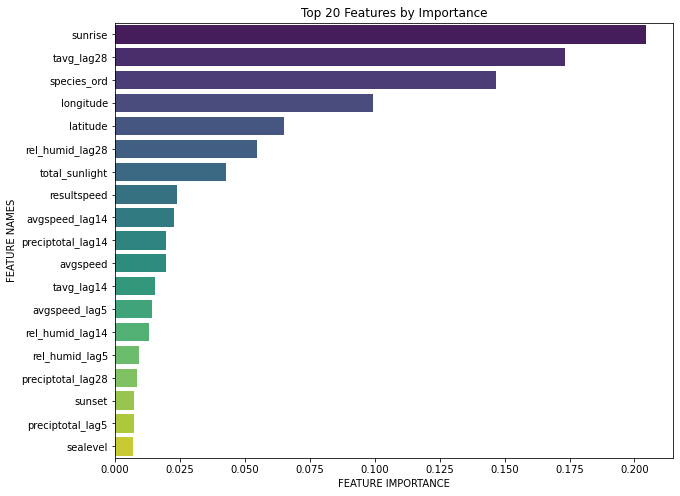

In [107]:
plot_feature_importance(gb_final.feature_importances_, Xsm.columns)

As seen above, the top feature turned out to be `sunrise`, followed by `tavg_lag28` and `species_ord`. Location features `longitude` and `latitude` were also important, while most of the top 20 features actually constituted the features that we engineered earlier during the EDA portion.

## Kaggle Submission

In [108]:
# Create submission dataframe
submission = test[['id']]
submission.columns = ['Id']

In [110]:
submission['WnvPresent'] = gb_final.predict_proba(test.drop(columns=['id', 'date']))[:, 1]

<ipython-input-110-137e02869a82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['WnvPresent'] = gb_final.predict_proba(test.drop(columns=['id', 'date']))[:, 1]


In [111]:
submission.head()

,Id,WnvPresent
0,1,0.014356
1,2,0.011987
2,3,0.014356
3,4,0.008199
4,5,0.008199


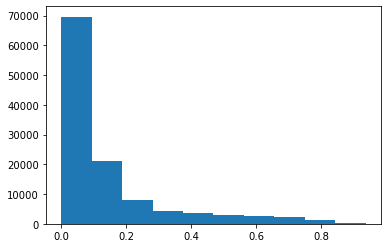

In [112]:
# Visualise distribution of predicted probabilities
plt.hist(submission['WnvPresent']);

In [114]:
# Export to csv file for submission
submission.to_csv('../assets/wnv_submission.csv', index=False)

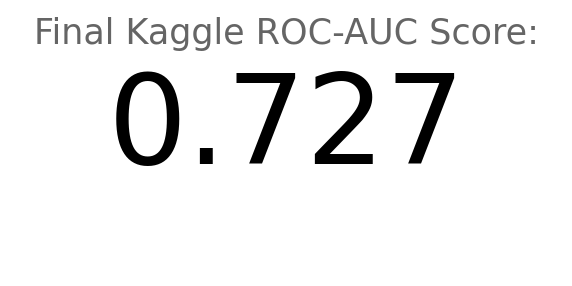

In [118]:
plt.figure(figsize=(10, 5))
plt.text(x = 0.5, y = 0.9, s = 'Final Kaggle ROC-AUC Score:', ha = 'center', va = 'center', size = 35, alpha = 0.6)
plt.text(x = 0.5, y = 0.55, s = '0.727', ha = 'center', va = 'center', size = 125, alpha = 1)
plt.axis('off');

# Cost-Benefit Analysis of Spraying

To determine the cost effectiveness of spraying, we first need to consider the following:<br>
**Direct costs**: These would mainly include the cost of procuring chemicals required for spraying. <br>
**Indirect costs**: These would be productivity/economic costs incurred from people seeking short/long term treatment for the west nile virus. <br>


### Cost of procuring chemicals for spraying

From [external research](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/august/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html), we know a few facts about sprays: <br>
1) spraying is usually conducted around 8pm till 1 am using trucks with low volume sprays, and the EPA approved spray is Zenivex. <br>
2) the spray rate is [1.5 ounces per acre](https://www.nbcchicago.com/news/local/city-to-spray-mosquito-killing-insecticide-wednesday-night/64951/). <br>
3) the cost per gallon (128 ounces) of Zenivex is [approximately \$ 300 USD.](http://www.gfmosquito.com/wp-content/uploads/2017/07/2017-ND-Mosq.-Control-Quotes-Tabulation.pdf) <br>
4) the city of chicago is approximately 145,300 acres in [total area](https://www.themeasureofthings.com/results.php?comp=area&unit=a&amt=160000&p=1). <br>

Therefore, in order to achieve "maximum" benefit, let's assume that the Chicago Department of Public Health (CDPH) adopts an aggressive approach towards culling the virus, and decides to conduct spraying on the whole of Chicago.

In [2]:
# Cost of procuring Zenivex to spray entire Chicago

# amount of spray (ounces) required to spray the whole of Chicago
spray_amt = 145300 / 1.5

#amount of spray in gallons
spray_gallon = spray_amt / 128

#costs of procuring the spray
spray_cost = spray_gallon * 300

spray_cost

227031.25

It costs the state \$227031 to purchase Zenivex for one spraying exercise for the whole of Chicago. Considering the maximum benefit scenario, we now assume that the CDPH takes into account the incubation period of mosquitos, and decides to do a bi-weekly spraying every summer for the whole of Chicago.

In [3]:
# Annual costs of spraying

annual_spray_cost = spray_cost * 6 

annual_spray_cost

1362187.5

In the maximum benefit scenario, the CDPH will need to set aside a budget of approximately **\$1.36 million** annually to conduct spraying for the whole of Chicago.

### Healthcare costs

The four specific "clinical syndromes" of the west nile virus are: fever, meningitis, encephalitis and acute flaccid paralysis (AFP), the more severe of which can lead to death or long-term disability. This implies productivity loss that translates into economic loss for Chicago.

Based on [external research](https://www.ajtmh.org/view/journals/tpmd/90/3/article-p402.xml), the mean productivity loss (2012) incurred for each syndrome are as follows:

| Fever | Meningitis | Encephalitis | Acute Flaccid Paralysis|
|:-------------: |:-------------:|:-----:|:---------:|
| \$546| \$684 | \$53,234 | \$12,357 |

We also know that in 2012, there were about [60 reported wnv cases](https://www.chicago.gov/content/dam/city/depts/cdph/statistics_and_reports/CDInfo_2013_JULY_WNV.pdf). We will use this as a proxy of annual wnv cases.

The [CDC website](https://www.cdc.gov/westnile/index.html) mentions that:
1)  most people infected with WNV do not feel sick <br>
2) about 1 in 5 people who are infected develop a fever and other symptoms <br>
3) about 1 out of 150 infected people develop serious or fatal illness <br>

This means that 12 out of 60 will develop a fever and possibly only 1 person will contract more serious illnesses like encephalitis and acute flaccid paralysis. The other 47 are likely asymptomatic.

In the maximum benefit scenario, we assume that as a result of aggressive spraying policy, no one in Chicago contracts the West Nile Virus.

###  Calculating Productivity costs

In [4]:
#assuming worst case... 12 people have developed fever and 1 person has contracted encephalitis

prod_costs = (12 * 546) + (1 * 53234)

prod_costs

59786

Assuming the maximum benefit scenario, the productivity savings for Chicago will be about \\$59,786, which does not justify the \$1.36 million of investment into purchasing Zenivex annually.

**Effectiveness of Spraying**

Earlier during our EDA (refer plot below), we saw that during year 2011 and 2013, spraying was conducted in several areas in the city.
However, we observed that even with spraying, particularly in 2013 (where spraying was the most), the number of positive WNV clusters still increases!

Hence, spraying will not be very useful as a short-term response to combat WNV.   
Next, we can take a look if spraying has any long term effect. We will use the results predicted by our model to fill in for 2012 and 2014.

![EDA plot](../assets/images/EDA-spray-plot.png)

In [40]:
spray = pd.read_csv('../assets/spray.csv')
spray["Date"] = pd.to_datetime(spray["Date"], format = "%Y-%m-%d")
spray.columns = [col.lower() for col in spray.columns]
spray['year'] = spray.date.dt.year
# Drop the outliers (spray but not within the area where train data is available)
spray.drop(spray.index[list(range(95))], inplace=True)

train['year'] = train.date.dt.year
test['year'] = test.date.dt.year

In [41]:
predicted_result = pd.read_csv('../assets/kaggleSubmission.csv')
predicted_result.columns = [col.lower() for col in predicted_result.columns]
predicted_result['wnvpresent'] = predicted_result['wnvpresent'].map(lambda x: 0 if x < 0.5 else 1)

In [42]:
update_test = test.merge(predicted_result, on='id')

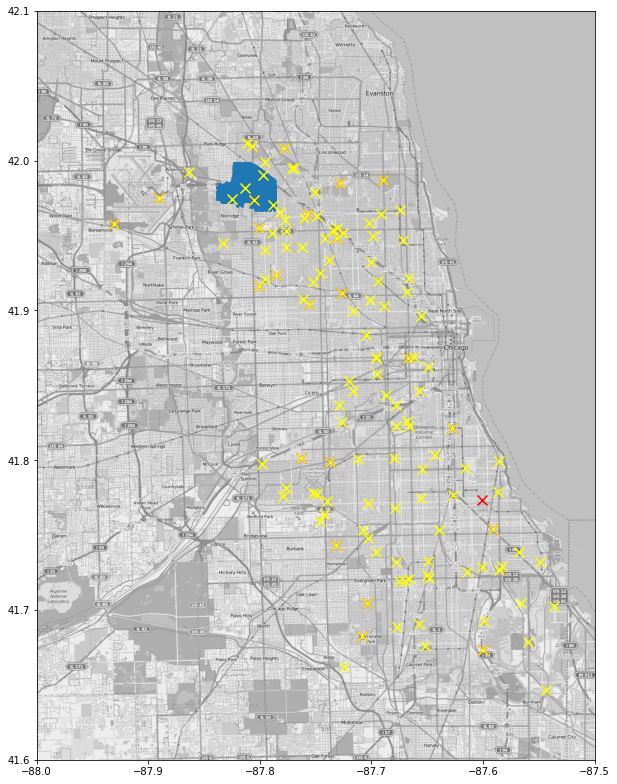

In [43]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
spray11 = spray[spray['year']==2011][['date','longitude', 'latitude']]
train11 = train[(train['year']==2011)&(train['wnvpresent']==1)][['date', 'longitude', 'latitude']]
pred12 = update_test[(update_test['year']==2012)&(update_test['wnvpresent']==1)][['date', 'longitude', 'latitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = spray11[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

yesno11 = train11[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno11[:,0], yesno11[:,1], marker='x', alpha=1, color='red', s=100)

yesno12 = pred12[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno12[:,0], yesno12[:,1], marker='x', alpha=1, color='yellow', s=100);

Above map shows the region (**blue**) where spraying was conducted in 2011.

**Red** crosses shows the places where WNV is positive in 2011, while the **yellow** crosses  is positive for 2012.
The crosses with **orange** body are places where WNV is positive for both 2011 AND 2012.

We can see that during 2011, the region spray only had 1 positive cluster in 2011, but had 5 positive clusters in 2012 instead.

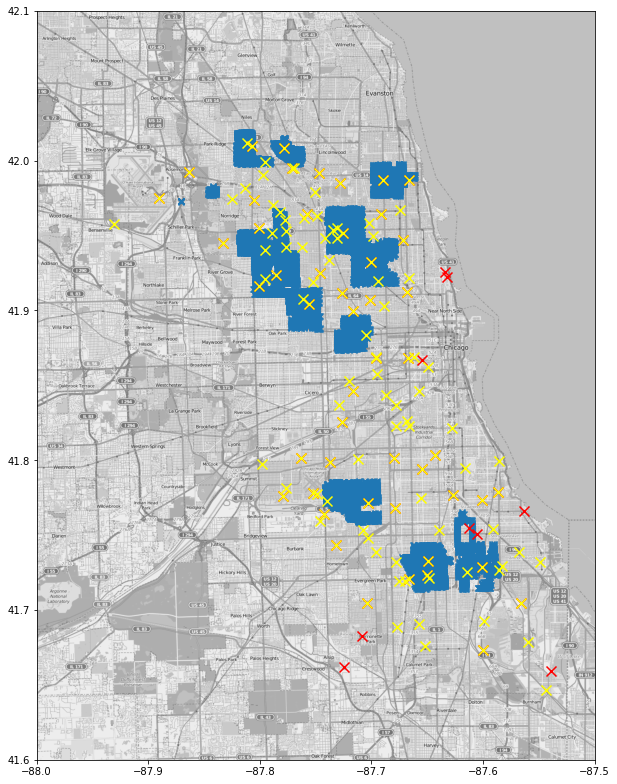

In [44]:
# Code is borrowed from: https://www.kaggle.com/users/213536/vasco/predict-west-nile-virus/west-nile-heatmap

mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")
spray13 = spray[spray['year']==2013][['date','longitude', 'latitude']]
train13 = train[(train['year']==2013)&(train['wnvpresent']==1)][['date', 'longitude', 'latitude']]
pred14 = update_test[(update_test['year']==2014)&(update_test['wnvpresent']==1)][['date', 'longitude', 'latitude']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = spray13[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(locations[:,0], locations[:,1], marker='x')

yesno13 = train13[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno13[:,0], yesno13[:,1], marker='x', alpha=1, color='red', s=100)

yesno14 = pred14[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(yesno14[:,0], yesno14[:,1], marker='x', alpha=1, color='yellow', s=100);

In 2013, there were 17 cases within the sprayed region, but the tally increased to 31 in 2014. Hence, spraying seems to have no long term effect here.

# Conclusions

<u>**Classification Model**</u>

The final model we built was successful in answering our problem statement (predictions on the possibility of West Nile Virus occurence on various locations in Chicago). Unfortunately, this model does not directly achieve the bigger goal of eradicating the West Nile Virus from Chicago. Most of the features in the model are beyond our control (such as weather), so inference would not directly help in suggesting ways to eradicate the virus.

However, this does not mean that the model is not helpful at all. We can utilise the model to improve existing efforts in eradicating the virus, such as spraying.

<u>**Optimize Spraying Parameters**</u>

Based on our findings above, we concluded that the current spraying efforts have not been very effective in controlling or eliminating the issue of West Nile Virus. In fact, [BeyondPesticides](https://www.beyondpesticides.org/resources/mosquitos-and-insect-borne-diseases/documents/the-truth-about-mosquitoes,-pesticides-and-west-nile-virus) also urges that spraying pesticides affects the public health and environment, in addition to not reducing WNV incidences. This is also supported by CDC, stating that spraying pesticides is usually the least efficient mosquito control technique [CDC](https://www.beyondpesticides.org/resources/mosquitos-and-insect-borne-diseases/documents/the-truth-about-mosquitoes,-pesticides-and-west-nile-virus).

Nevertheless, it could be improved in terms of both cost effectiveness and efficacy by taking into account the factors below:

1. Location
    - Spraying can be targeted at locations where our model predicts to have a high probability of the occurence of the virus
2. Time of year  
    - Spraying efforts can be ramped up at the appropriate time of the year (July to August) to reduce mosquito population
3. Spray and wind direction
    - Research shows that spraying along and against the wind will incur different efficacy. However, this needs further research as this can be a topic on its own.

## Other Recommendations

During our external subject background research, we also uncovered several recommendations that any organization or even individual should follow:

<u>**Public Education**</u>
  
The health government agency should start spread awareness, drive campaigns and educate the public on actions that each individual can take to contribute towards the fight in eradicating WNV. There is only so much that the state or city agency in charge can do, and if the public chips in effort to ward off mosquito breeding grounds and take individual care, then the WNV cases will drop (hopefully to zero!).

<u>**Manual Prevention**</u>

The most effective way is to avoid getting bitten by mosquitos! The following measures could be promoted to the public during campaigns:

- Use insect repellent, wear long-sleeved clothings, install mosquito traps or barriers at home [CDC](https://www.cdc.gov/westnile/prevention/index.html#:~:text=There%20is%20no%20vaccine%20to,control%20mosquitoes%20indoors%20and%20outdoors)
- Perform checks around home to clear mosquito breeding grounds

<u>**Enforcement Checks**</u>

As another developed country with a high prevalence of mosquito-borne diseases, Singapore has been quite effective in fighting the constant outbreaks of dengue in the country. One of the main methods it does so is by enforcing checks on households to ensure that there are no potential breeding grounds for mosquitos. Chicago could adopt a similar approach in order to combat the mosquito population and consequently reduce incidences of the virus.